Example: Running the Stokes code to explore topographic decay on floating viscous sheets

The code requires FEniCS---see the README for details.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../source')

from main import solve
from params import H, t_e, t_r
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from ufl import cos
from mesh_routine import deform_mesh, get_surfaces
from dolfinx.mesh import create_rectangle
from mpi4py import MPI
from post_process import get_decay_rate
from theory import t_p, t_m

Plot theoretical decay timescale from linearized analysis:

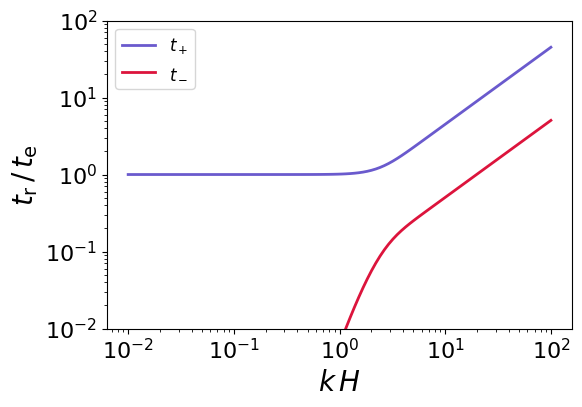

In [2]:
k = np.logspace(-2,2,100)
t_theory = t_p(k)
t_hydro = t_m(k)

%matplotlib inline 
plt.figure(figsize=(6,4))
plt.plot(k,t_theory,color='slateblue',linewidth=2,label=r'$t_+$')
plt.plot(k,t_hydro,color='crimson',linewidth=2,label=r'$t_-$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,1e2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$k\,H$',fontsize=20)
plt.ylabel(r'$t_\mathrm{r}\,/\,t_\mathrm{e}$',fontsize=20)
plt.legend(fontsize=12)
plt.show()

Define sinusoidal perturbation for surface initial condition:

In [4]:
# # sinusoidal anomaly for perturbing domain
lamda = 1e1*H                      # wavelength
k = (2*np.pi/lamda)                 # wavenumber
perturb = lambda x: 5*cos(k*x)      # surface perturbation

Find theoretical timescale for this wavenumber (to set final time for simulation):

In [5]:
k*H

0.6283185307179586

In [6]:
t_th = t_p(k*H)  # theoretical decay time (relative to t_e)
t_hy = t_m(k*H)
print('slow decay = '+'{:.2f}'.format(t_th))
print('fast decay = '+'{:.2f}'.format(t_hy))

slow decay = 1.00
fast decay = 0.00


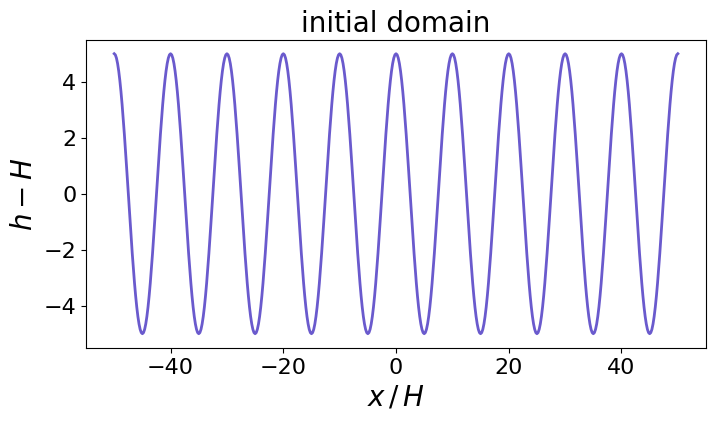

In [7]:
# Time-stepping parameters
t_f = 30*t_e                    # Final time (in terms of intrinsic timescale)
nt = 100*int(t_f/t_e)               # Number of time steps
t = np.linspace(0,t_f, nt)         # timesteps array

# Mesh parameters
L = 10*lamda                       # length of domain
Nx = 500                           # Number of elements in x direction
Nz = 10                            # Number of elements in z direction

# create domain
domain = create_rectangle(MPI.COMM_WORLD,[[-L/2.0,0.0],[L/2.0,H]], [Nx, Nz])

# deform the upper surface of the domain accoriding to the perturbation
domain = deform_mesh(domain,perturb)

# get surfaces of the domain for plotting the initial condition
h_i,s_i,x = get_surfaces(domain)

# plot the initial surface profile
%matplotlib inline 
plt.figure(figsize=(8,4))
plt.title('initial domain',fontsize=20)
plt.plot(x/H,h_i-H,color='slateblue',linewidth=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$h-H$',fontsize=20)
plt.xlabel(r'$x\,/\,H$',fontsize=20)
plt.show()
plt.close()

Solve the topographic decay problem

In [8]:
# solve the problem
h,s,x = solve(domain,t)

Uncomment below to make a movie (in 'movie' directory) to watch the solution evolve

In [ ]:
# !rm -r movie
# !mkdir movie

# mpl.use('agg')

# ind = np.arange(0,t.size,4)
# j=0
# for i in ind:
#     plt.figure(figsize=(8,6))
#     plt.suptitle(r'$t\,/\,t_\mathrm{e}=$'+'{:.2f}'.format(t[i]/t_e),y=1.04,fontsize=26,bbox=dict(boxstyle='round', facecolor='w', alpha=1))
#     plt.subplot(211)
#     plt.plot(x/H,h[:,i]-H,'-',color='slateblue',linewidth=2)
#     plt.ylim((h-H).min()-2,(h-H).max()+2)
#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.ylabel(r'$h-H$',fontsize=20)
#     plt.gca().xaxis.set_ticklabels([])
    
#     plt.subplot(212)
#     plt.plot(x/H,s[:,i],'-',color='slateblue',linewidth=2)
#     plt.ylim(s.min()-2,s.max()+2)
#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.ylabel(r'$s$',fontsize=20)
#     plt.xlabel(r'$x\,/\,H$',fontsize=20)
    
#     plt.tight_layout()
#     plt.savefig('./movie/'+str(j),bbox_inches='tight')
#     # plt.show()
#     plt.close()
#     j+=1

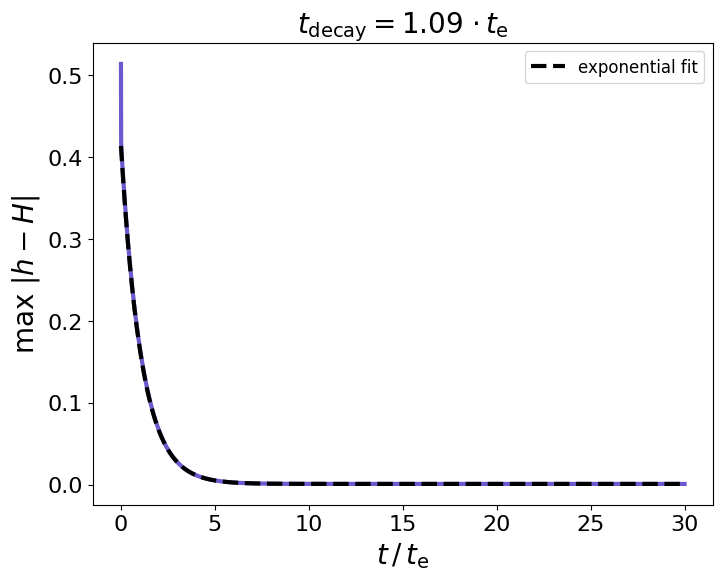

In [14]:
# define maximum anomaly over time
h_max = np.max(np.abs(h-H)/H,axis=0)

t_decay,h_pred = get_decay_rate(h_max,t)
        
%matplotlib inline 
plt.figure(figsize=(8,6))
plt.title(r'$t_\mathrm{decay}=$'+'{:.2f}'.format(t_decay)+r' $\cdot \,t_\mathrm{e}$' ,fontsize=20)
plt.plot(t/t_e,h_max*H,'-',color='slateblue',linewidth=3)
plt.plot(t/t_e,h_pred(t/t_e)*H,color='k',linestyle='--',linewidth=3,label=r'exponential fit')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$t\,/\,t_\mathrm{e}$',fontsize=20)
plt.ylabel(r'max $|h-H|$',fontsize=20)
plt.legend(fontsize=12)
plt.show()
plt.close()